### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datacube.utils import masking

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.dask import create_local_dask_cluster

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:38619 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 31 Memory: 254.70 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app="Vegetation_anomalies")

In [4]:
# Define the area of interest
lat, lon = 9.8892,-0.9271 #near Lake Tana, Ethiopia
buffer = 0.15

# Set the range of dates for the climatology
time_range = ('1984', '2020')

# year and month for anomaly
year = '2021'
month = 'December'

# some final specifications
resolution = (-30, 30)
dask_chunks = dict(x=1000,y=1000)

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [ ]:
# display_map(x=lon_range, y=lat_range)

### Define a function for filtering data to the month of interest

In [5]:
months = {'January': [1],
           'February': [2],
           'March': [3],
           'April': [4],
           'May': [5],
           'June': [6],
           'July': [7],
           'August': [8],
           'September': [9],
           'October': [10],
           'November': [11],
           'December': [12]
          }

def filter_month(dataset):
    dss = []
    if dataset.time.begin.month in months[month]:
        dss.append(dataset)
    return dss

## Load cloud-masked Landsat data
The first step in this analysis is to load in Landsat data for the `lat_range`, `lon_range` and `time_range` we provided above. 
The code below uses the `load_ard` function to load in data from the Landsat 5, 7 and 8 satellites for the area and time specified.
For more information, see the [Using load_ard notebook](../Frequently_used_code/Using_load_ard.ipynb).

The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data:

In [6]:
# Create the 'query' dictionary object, which contains the longitudes, 
# latitudes and time provided above
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['red','green','blue','nir', 'pixel_quality'],
    'resolution': resolution,
    'output_crs':'epsg:6933',
    'dask_chunks':dask_chunks
}

# Load available data Landsat 8
ds = load_ard(dc=dc, 
              products=['ls5_sr','ls7_sr','ls8_sr'], 
              group_by='solar_day',
              mask_pixel_quality=True,
#               predicate=filter_month,
              mask_filters=[("opening", 5),("dilation", 5)], #improve cloud-mask
              **query)


Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls5_sr
    ls7_sr
    ls8_sr
Applying morphological filters to pq mask [('opening', 5), ('dilation', 5)]
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 467 time steps as a dask array


In [ ]:
from datacube.utils import masking
flags_def = ds.pixel_quality.attrs["flags_definition"]
quality_flags = dict(
                cloud="high_confidence", # True where there is cloud
                cloud_shadow="high_confidence",# True where there is cloud shadow 
)

# set cloud_mask: True=cloud, False=non-cloud
mask, _= masking.create_mask_value(flags_def, **quality_flags)

#add the cloud mask to our dataset
cloud_mask = (ds['pixel_quality'] & mask) != 0

In [ ]:
missed_cloud =  ds['blue'] >= 0.375

In [ ]:
from odc.algo._masking import mask_cleanup
# missed_cloud

In [ ]:
missed_cloud_d = mask_cleanup(missed_cloud, mask_filters=[("dilation", 5)])

In [ ]:
missed_cloud_d = missed_cloud_d.compute()

In [ ]:
# xr.ufuncs.logical_or(cloud_mask.isel(time=220), missed_cloud_d.isel(time=220)).plot.imshow()

In [ ]:
# rgb(ds, index=226)

In [ ]:
missed_cloud_d.isel(time=slice(200,230)).plot.imshow(col='time', col_wrap=10)

In [ ]:
missed_cloud.isel(time=slice(200,230)).plot.imshow(col='time', col_wrap=10)

In [ ]:
missed_cloud_d.isel(time=220).plot.imshow()

In [7]:
xx = ds.where(ds.blue < 0.375)
xx

<xarray.Dataset>
Dimensions:        (time: 467, y: 1258, x: 966)
Coordinates:
  * time           (time) datetime64[ns] 1984-11-05T09:50:37.652006 ... 2020-...
  * y              (y) float64 1.274e+06 1.274e+06 ... 1.237e+06 1.237e+06
  * x              (x) float64 -1.039e+05 -1.039e+05 ... -7.502e+04 -7.498e+04
    spatial_ref    int32 6933
Data variables:
    red            (time, y, x) float32 dask.array<chunksize=(1, 1000, 966), meta=np.ndarray>
    green          (time, y, x) float32 dask.array<chunksize=(1, 1000, 966), meta=np.ndarray>
    blue           (time, y, x) float32 dask.array<chunksize=(1, 1000, 966), meta=np.ndarray>
    nir            (time, y, x) float32 dask.array<chunksize=(1, 1000, 966), meta=np.ndarray>
    pixel_quality  (time, y, x) float64 dask.array<chunksize=(1, 1000, 966), meta=np.ndarray>
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [8]:
xx = xx.compute()
xx

CPLReleaseMutex: Error = 1 (Operation not permitted)


<xarray.Dataset>
Dimensions:        (time: 467, y: 1258, x: 966)
Coordinates:
  * time           (time) datetime64[ns] 1984-11-05T09:50:37.652006 ... 2020-...
  * y              (y) float64 1.274e+06 1.274e+06 ... 1.237e+06 1.237e+06
  * x              (x) float64 -1.039e+05 -1.039e+05 ... -7.502e+04 -7.498e+04
    spatial_ref    int32 6933
Data variables:
    red            (time, y, x) float32 0.1009 0.1009 0.1009 ... 0.1735 0.201
    green          (time, y, x) float32 0.09821 0.09455 0.09455 ... 0.1218 0.145
    blue           (time, y, x) float32 0.0665 0.06485 ... 0.08363 0.09675
    nir            (time, y, x) float32 0.2379 0.2417 0.2456 ... 0.3089 0.3306
    pixel_quality  (time, y, x) float64 5.44e+03 5.44e+03 ... 2.182e+04
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [9]:
ndvi = calculate_indices(xx, 'NDVI', collection='c2', drop=True)

Dropping bands ['red', 'green', 'blue', 'nir', 'pixel_quality']


In [11]:
cc = xr.ufuncs.isnan(ndvi.NDVI)
cc = xr.ufuncs.logical_not(cc)

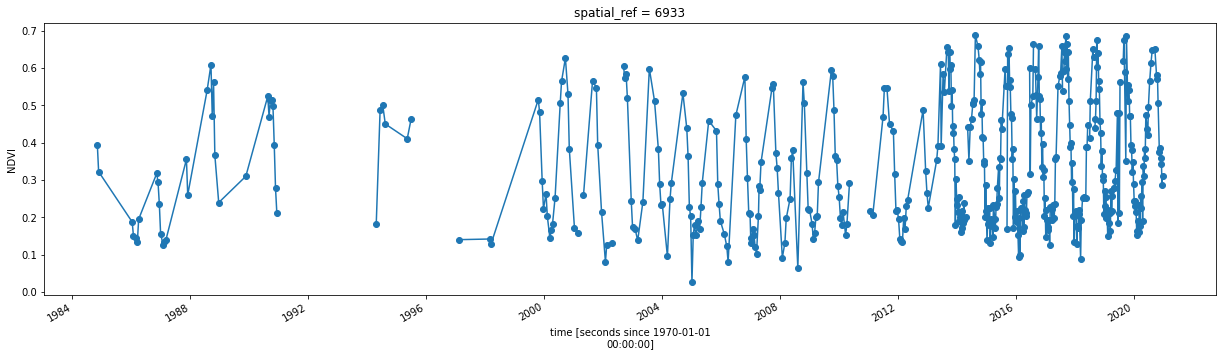

In [10]:
ndvi.NDVI.mean(['x','y']).plot(figsize=(21,5), marker='o')

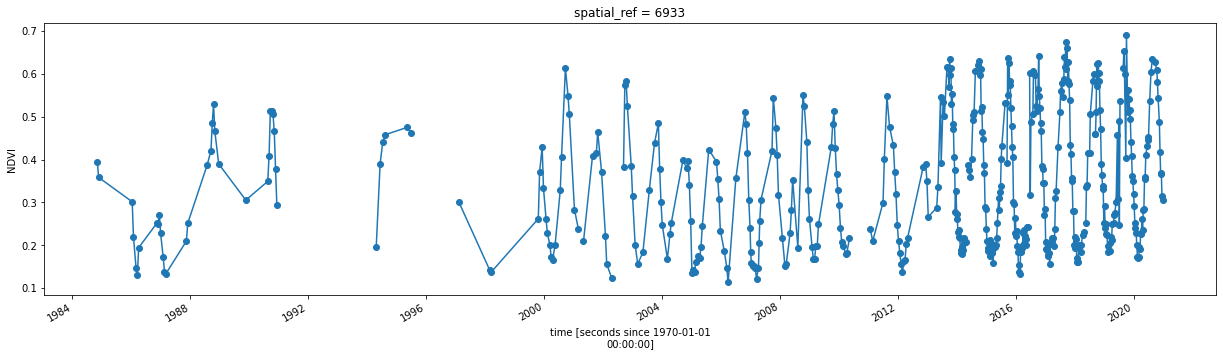

In [18]:
ndvi.NDVI.rolling(time=3, min_periods=1).mean().where(cc).mean(['x','y']).plot(figsize=(21,5), marker='o')

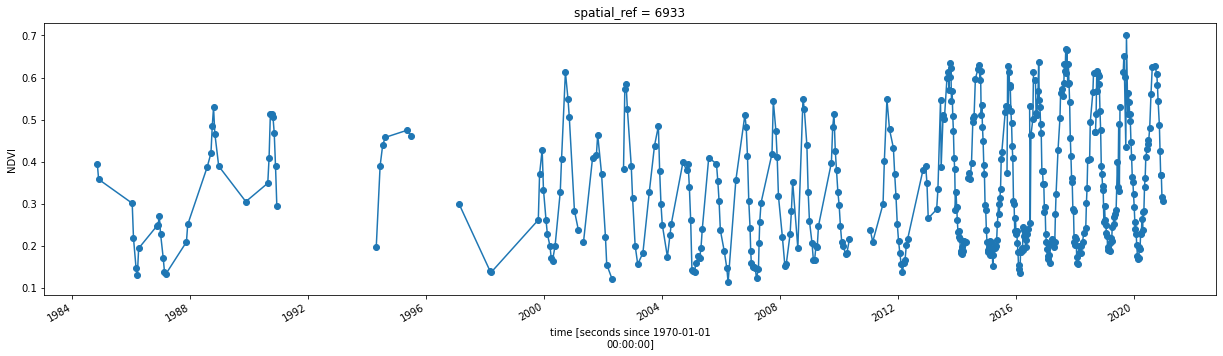

In [24]:
ndvi.NDVI.interpolate_na(dim='time', method='quadratic', limit=3, max_gap='6W').rolling(time=3, min_periods=1).mean().where(cc).mean(['x','y']).plot(figsize=(21,5), marker='o');

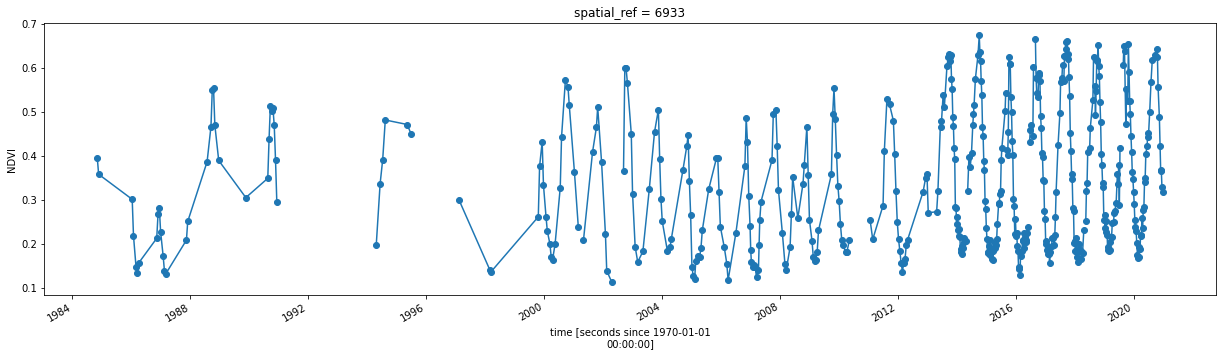

In [23]:
ndvi.NDVI.fillna(ndvi.NDVI.median(['x','y'])).rolling(time=3, min_periods=1).mean().where(cc).mean(['x','y']).plot(figsize=(21,5), marker='o');

In [ ]:
ds = ds.compute()

In [ ]:
# rgb(ds, index=5, size=12)

In [ ]:
# rgb(xx, index=5, size=12)

In [ ]:
rgb(xx, index=221, size=12)

In [ ]:
xx.blue.isel(time=221).plot(figsize=(8,8), vmin=0)

In [ ]:
ds.blue.isel(time=5).plot()

In [ ]:
rgb(_rgb, index=5)

In [ ]:
x = ndvi.NDVI.time.values.astype('datetime64[M]').astype(int) % 12 + 1 == 10

In [ ]:
y = ndvi.isel(time=x)

In [ ]:
y.time

In [ ]:
# _rgb = ds[['red', 'green', 'blue']].compute()

In [ ]:
y.NDVI.plot.imshow(col='time', col_wrap=10, vmax=1.0, vmin=0)

In [ ]:
rgb(y, index=33)

In [ ]:
rgb(y,  col='time', col_wrap=10)

In [ ]:
j = ds.time.values.astype('datetime64[M]').astype(int) % 12 + 1 == 4

In [ ]:
i = ds.isel(time=j)

In [ ]:
ndvi = calculate_indices(i, 'NDVI', collection='c2', drop=True)

In [ ]:
ndvi = ndvi.compute()

In [ ]:
ndvi.NDVI.isel(time=33).plot.imshow()

In [ ]:
ndvi.NDVI.isel(time=slice(30,40)).plot.imshow(col='time', col_wrap=10, vmax=1, vmin=0)

In [ ]:
ds.blue.isel(time=221).plot.imshow(vmax=1, vmin=0)

In [ ]:
ds.blue.isel(time=slice(0, 100)).plot.imshow(col='time', col_wrap=10, vmax=1, vmin=0)

## Calculate NDVI climatologies

This will take a few minutes to run because we will bring the climatologies into memory. Check the Dask dashboard to see progress. Access the dashboard by clicking on the Dashboard link generated when you created the cluster.

In [ ]:
#calculate NDVI
ndvi = calculate_indices(ds, 'NDVI', collection='c2', drop=True)

# Remove NDVI's that aren't between 0 and 1
ndvi = ndvi.where((ndvi >= 0) & (ndvi <= 1))

#bring into distributed memory to save loading twice
ndvi = ndvi.persist() 

# #calculate the climatologies and bring into memory
# climatology_mean = ndvi.mean("time").NDVI.compute()
# climatology_std = ndvi.std("time").NDVI.compute()

In [ ]:
ndvi.NDVI.isel(time=slice(0,10)).plot.imshow(col='time', col_wrap=10);

## Generate a clear pixel count summary

This will help us understand how many observations are going into the NDVI climatology calculations. Too few observations might indicate a bias in the climatology. Remember, the role of the climatology is to define 'average' conditions, too few observations will not provide a realistic estimation of the typical conditions.

In [ ]:
pq_count = xr.ufuncs.isnan(ndvi['NDVI']) 
pq_count = xr.ufuncs.logical_not(pq_count) #invert
pq_count = pq_count.sum('time')

In [ ]:
pq_count.plot(figsize=(7,7))
plt.title('Clear pixel count for NDVI climatologies');

## Calculate standardised anomalies

Step 1: Load data from the month we're analysing

Step 2. Calculate the mean NDVI during the month

In [ ]:
month_query = {
    'x': lon_range,
    'y': lat_range,
    'time': (year+'-'+str(months[month][0])),
    'measurements': ['red','nir'],
    'resolution': resolution,
    'output_crs':'epsg:6933',
    'dask_chunks':dask_chunks
}

# Load available data, Landsat 8 only
month_ds = load_ard(dc=dc, 
              products=['ls8_sr'], 
              group_by='solar_day',
              predicate=filter_month,
              **month_query)

#calculate mean NDVI
month_ndvi = calculate_indices(month_ds, 'NDVI', collection='c2', drop=True)
month_mean = month_ndvi.mean('time').NDVI.compute()

Step 3: Now we can calculate the standardised anomalies by subtracting the long-term mean and dividing by the long-term standard deviation

In [ ]:
stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    month_mean,
    climatology_mean,
    climatology_std,
    output_dtypes=[ds.red.dtype],
    dask="allowed"
)

## Incorporating DE Africa's cropland extent map

Load the cropland mask over the region of interest. The default analysed here is in Ethiopia, so we need to load the [crop_mask_eastern](https://docs.digitalearthafrica.org/en/latest/data_specs/Cropland_extent_specs.html) product, which cover the countries of Ethiopia, Kenya, Tanzania, Rwanda, and Burundi.

In [ ]:
cm = dc.load(product='crop_mask_eastern',
            time=('2019'),
            measurements='filtered',
            resampling='nearest', 
            like=ds.geobox).filtered.squeeze()

cm.plot.imshow(add_colorbar=False, figsize=(7,7))
plt.title('Cropland Extent');

### Plot NDVI climatolgies, seasonal mean, and anomalies for cropping regions only

Below we mask out the regions that aren't cropping, revealing only the condition of the cropped regions. 

In [ ]:
#mask layers with crop-mask
climatology_mean=climatology_mean.where(cm, np.nan)
climatology_std=climatology_std.where(cm, np.nan)
month_mean=month_mean.where(cm, np.nan)
stand_anomalies=stand_anomalies.where(cm, np.nan)

In [ ]:
#plot al layers
plt.rcParams['axes.facecolor'] = 'gray' # makes transparent pixels obvious
fig,ax = plt.subplots(2,2, sharey=True, sharex=True, figsize=(15,15))

climatology_mean.plot.imshow(ax=ax[0,0], cmap='YlGn' ,vmin=0, vmax=0.75)
ax[0,0].set_title('NDVI: '+month+' mean climatology')
climatology_std.plot.imshow(ax=ax[0,1], vmin=0, vmax=0.25)
ax[0,1].set_title('NDVI: '+month+' std dev climatology')
month_mean.plot.imshow(ax=ax[1,0], cmap='YlGn', vmin=0, vmax=0.75)
ax[1,0].set_title('NDVI: '+year+" "+month+' mean')
stand_anomalies.plot.imshow(ax=ax[1,1], cmap='BrBG',vmin=-2, vmax=2)
ax[1,1].set_title('NDVI: '+year+" "+month+' standardised anomaly')
plt.tight_layout();

## Drawing Conclusions

Here are some questions to think about:

1. How does the seasonal NDVI mean compare with the long term mean of NDVI?
2. Do the cropping regions tend to have high or low standard deviations in NDVI?
3. Looking at the map of standardised anomalies, are the crops fairing better or worse than average? And how unusual are the anomalies compared with average? 
4. What are other environmental data might help us confirm the drivers of the changes in NDVI?

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')